In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

In [2]:
def generate_data(seq_length=1000):
    x = np.linspace(0, 100, seq_length)
    y = np.sin(x)
    return y

data = generate_data()

In [3]:
def generate_synthetic_data_univariate(seq_length=100, freq=0.1, noise_level=0.1):
    t = np.linspace(0, seq_length * freq, seq_length)
    data = np.sin(t) + noise_level * np.random.randn(seq_length)
    return data

def generate_synthetic_data_multivariate(seq_length=100, freq=0.1, noise_level=0.1):
    t = np.linspace(0, seq_length * freq, seq_length)
    data1 = np.sin(t) + noise_level * np.random.randn(seq_length)
    data2 = np.cos(t) + noise_level * np.random.randn(seq_length)
    return np.column_stack([data1, data2])

In [4]:
def create_sequences(data, seq_length):
    X, Y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        Y.append(data[i + 1:i + seq_length + 1])  # Shift by 1 step
    return torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32)

seq_length = 20
X, Y = create_sequences(data, seq_length)

X = X.unsqueeze(-1)
Y = Y.unsqueeze(-1)

train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

C:\Users\naman\AppData\Local\Temp\ipykernel_13668\3832586225.py:6: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  return torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32)


In [5]:
# class TransformerTimeSeries(nn.Module):
#     # def __init__(self, input_dim, model_dim, num_heads, num_layers, dropout=0.1):
#     #     super(TransformerTimeSeries, self).__init__()
#     #     self.model_dim = model_dim

#     #     self.transformer = nn.Transformer(
#     #         d_model=model_dim, 
#     #         nhead=num_heads, 
#     #         num_encoder_layers=num_layers, 
#     #         num_decoder_layers=num_layers,
#     #         dropout=dropout,
#     #         batch_first=True
#     #     )

#     #     self.input_fc = nn.Linear(input_dim, model_dim)
#     #     self.output_fc = nn.Linear(model_dim, input_dim)

#     def __init__(self, input_dim, model_dim, num_heads, num_layers, dropout):
#         super(TransformerTimeSeries, self).__init__()

#         self.input_proj = nn.Linear(input_dim, model_dim)  # Project input_dim → model_dim

#         encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dropout=dropout)
#         decoder_layer = nn.TransformerDecoderLayer(d_model=model_dim, nhead=num_heads, dropout=dropout)

#         self.transformer = nn.Transformer(d_model=model_dim,
#                                           encoder_layer=encoder_layer,
#                                           decoder_layer=decoder_layer,
#                                           num_encoder_layers=num_layers,
#                                           num_decoder_layers=num_layers)

#         self.output_layer = nn.Linear(model_dim, input_dim)  # Output back to 2 features

#     # def forward(self, src, tgt):
#     #     src = self.input_fc(src)
#     #     tgt = self.input_fc(tgt)  

#     #     src = src.permute(1, 0, 2)
#     #     tgt = tgt.permute(1, 0, 2)

#     #     output = self.transformer(src, tgt)

#     #     output = self.output_fc(output.permute(1, 0, 2))
#     #     return output

#     def forward(self, src, tgt):
#     # Assuming src: [batch_size, seq_len, input_dim]
#         src = src.permute(1, 0, 2)  # [seq_len, batch_size, input_dim]
#         tgt = tgt.permute(1, 0, 2)
    
#         output = self.transformer(src, tgt)
#         output = output.permute(1, 0, 2)  # [batch_size, seq_len, model_dim]
    
#         # Only take last output from the sequence
#         output = self.decoder(output[:, -1, :])  # [batch_size, output_dim]
#         return output

In [6]:
class TransformerTimeSeries(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, dropout):
        super(TransformerTimeSeries, self).__init__()

        self.input_proj = nn.Linear(input_dim, model_dim)

        self.transformer = nn.Transformer(
            d_model=model_dim,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dropout=dropout,
            batch_first=True
        )

        self.output_layer = nn.Linear(model_dim, input_dim)

    def forward(self, src, tgt):
        # Project inputs to model_dim
        src = self.input_proj(src)  # [batch_size, seq_len, model_dim]
        tgt = self.input_proj(tgt)

        # Permute to match transformer format
        src = src.permute(1, 0, 2)  # [seq_len, batch_size, model_dim]
        tgt = tgt.permute(1, 0, 2)

        # Forward through transformer
        output = self.transformer(src, tgt)

        # Permute back and map to original output dimension
        output = output.permute(1, 0, 2)
        return self.output_layer(output)

In [7]:
input_dim = 1
model_dim = 64
num_heads = 4
num_layers = 2
dropout = 0.1

model = TransformerTimeSeries(input_dim, model_dim, num_heads, num_layers, dropout)

In [8]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 50
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train, X_train)
    loss = criterion(output, Y_train)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

Epoch 10/50, Loss: 0.2791
Epoch 20/50, Loss: 0.0951
Epoch 30/50, Loss: 0.0541
Epoch 40/50, Loss: 0.0403
Epoch 50/50, Loss: 0.0301


In [ ]:
X_train.size

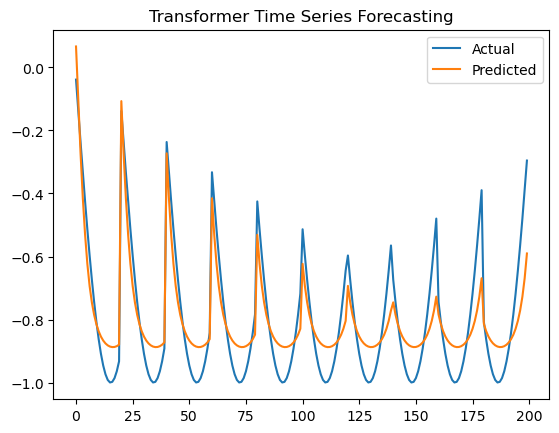

In [9]:
model.eval()
with torch.no_grad():
    Y_pred = model(X_test, X_test)

Y_test_np = Y_test.numpy().flatten()
Y_pred_np = Y_pred.numpy().flatten()

plt.plot(Y_test_np[:200], label="Actual")
plt.plot(Y_pred_np[:200], label="Predicted")
plt.legend()
plt.title("Transformer Time Series Forecasting")
plt.show()

Epoch [10/100], Loss: 0.1560
Epoch [20/100], Loss: 0.1595
Epoch [30/100], Loss: 0.1399
Epoch [40/100], Loss: 0.1358
Epoch [50/100], Loss: 0.1297
Epoch [60/100], Loss: 0.1247
Epoch [70/100], Loss: 0.1203
Epoch [80/100], Loss: 0.1107
Epoch [90/100], Loss: 0.0946
Epoch [100/100], Loss: 0.0977
Training completed.


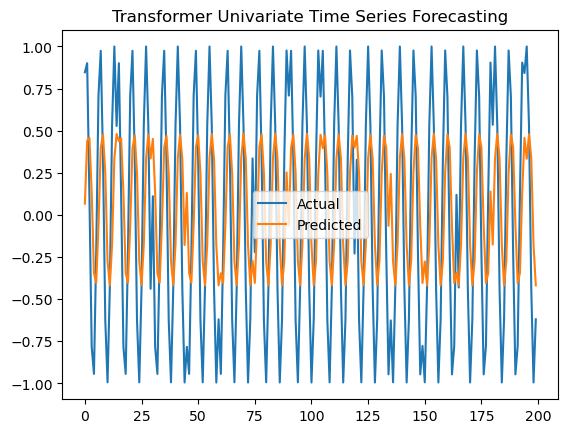

In [10]:
# Generate univariate data
seq_length = 100
data_univariate = generate_data(seq_length)  # Using same function as RNN

# Normalize data
scaler = MinMaxScaler()
data_univariate_scaled = scaler.fit_transform(data_univariate.reshape(-1, 1))

# Prepare sequences
window_size = 15
X_train_univariate, Y_train_univariate = create_sequences(data_univariate_scaled, window_size)

# Initialize Transformer model
input_dim = 1  # Univariate time series
model_dim = 64
num_heads = 4
num_layers = 2
dropout = 0.1

model = TransformerTimeSeries(input_dim, model_dim, num_heads, num_layers, dropout)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    Y_pred = model(X_train_univariate, X_train_univariate)

    # Compute loss
    loss = criterion(Y_pred, Y_train_univariate)

    # Backward pass
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

print("Training completed.")

# Make predictions
model.eval()
with torch.no_grad():
    Y_pred_univariate = model(X_train_univariate, X_train_univariate)

# Convert predictions back to original scale
Y_pred_univariate_np = scaler.inverse_transform(Y_pred_univariate.numpy().flatten().reshape(-1, 1))
Y_train_univariate_np = scaler.inverse_transform(Y_train_univariate.numpy().flatten().reshape(-1, 1))

# Plot results
plt.plot(Y_train_univariate_np[:200], label="Actual")
plt.plot(Y_pred_univariate_np[:200], label="Predicted")
plt.legend()
plt.title("Transformer Univariate Time Series Forecasting")
plt.show()

Epoch [10/100], Loss: 0.1099
Epoch [20/100], Loss: 0.1292
Epoch [30/100], Loss: 0.1116
Epoch [40/100], Loss: 0.1018
Epoch [50/100], Loss: 0.0851
Epoch [60/100], Loss: 0.0537
Epoch [70/100], Loss: 0.0271
Epoch [80/100], Loss: 0.0198
Epoch [90/100], Loss: 0.0169
Epoch [100/100], Loss: 0.0152
Training completed.


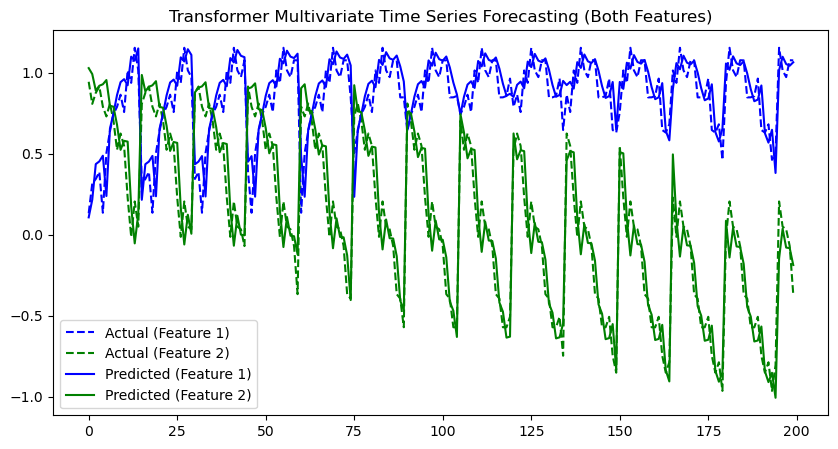

In [11]:
# Generate multivariate data
seq_length = 100
data_multivariate = generate_synthetic_data_multivariate(seq_length)

# Normalize data
scaler = MinMaxScaler()
data_multivariate_scaled = scaler.fit_transform(data_multivariate)

# Prepare sequences
window_size = 15
X_train_multivariate, Y_train_multivariate = create_sequences(data_multivariate_scaled, window_size)

# Initialize Transformer model
input_dim = data_multivariate.shape[1]  # Multivariate time series (number of features)
model_dim = 64
num_heads = 4
num_layers = 2
dropout = 0.1

model = TransformerTimeSeries(input_dim, model_dim, num_heads, num_layers, dropout)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    Y_pred = model(X_train_multivariate, X_train_multivariate)

    # Compute loss
    loss = criterion(Y_pred, Y_train_multivariate)

    # Backward pass
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

print("Training completed.")

# Make predictions
model.eval()
with torch.no_grad():
    Y_pred_multivariate = model(X_train_multivariate, X_train_multivariate)

# Convert predictions back to original scale
Y_pred_multivariate_np = scaler.inverse_transform(Y_pred_multivariate.numpy().reshape(-1, data_multivariate.shape[1]))
Y_train_multivariate_np = scaler.inverse_transform(Y_train_multivariate.numpy().reshape(-1, data_multivariate.shape[1]))

plt.figure(figsize=(10, 5))

# Plot actual values
plt.plot(Y_train_multivariate_np[:200, 0], label="Actual (Feature 1)", linestyle='dashed', color='blue')
plt.plot(Y_train_multivariate_np[:200, 1], label="Actual (Feature 2)", linestyle='dashed', color='green')

# Plot predicted values
plt.plot(Y_pred_multivariate_np[:200, 0], label="Predicted (Feature 1)", color='blue')
plt.plot(Y_pred_multivariate_np[:200, 1], label="Predicted (Feature 2)", color='green')

plt.legend()
plt.title("Transformer Multivariate Time Series Forecasting (Both Features)")
plt.show()

In [12]:
# Load Tesla stock data
df_tesla = pd.read_excel("Tesla_Stock.xlsx")

# Drop unnecessary column
df_tesla = df_tesla.drop(columns=["Unnamed: 0"], errors="ignore")

# Convert date to datetime and set as index
df_tesla["Date"] = pd.to_datetime(df_tesla["Date"])
df_tesla.set_index("Date", inplace=True)

# Select only "Open" and "Close" prices
df_tesla = df_tesla[["Open", "Close"]]

# Normalize data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_tesla)

df_scaled = pd.DataFrame(scaled_data, columns=df_tesla.columns, index=df_tesla.index)

# Use the last 500 data points
df_scaled = df_scaled.iloc[-500:]

In [13]:
# Split data into 80% training, 20% testing
train_size = int(len(df_scaled) * 0.8)
df_train = df_scaled.iloc[:train_size]
df_test = df_scaled.iloc[train_size:]

print(f"Training data size: {len(df_train)}")
print(f"Testing data size: {len(df_test)}")

Training data size: 400
Testing data size: 100


In [14]:
# Define hyperparameter search space
model_dims = [16, 32]
learning_rates = [0.01, 0.005, 0.001]
epochs_list = [100, 300, 500]
window_sizes = [5, 10, 15]

best_rmse = float("inf")
best_params = None

# Hyperparameter tuning
for model_dim in model_dims:
    for learning_rate in learning_rates:
        for epochs in epochs_list:
            for window_size in window_sizes:
                print(f"Training with ModelDim={model_dim}, LR={learning_rate}, Epochs={epochs}, Window={window_size}")

                # Prepare training data as sequences
                X_train_tesla_tuned = [df_train.values[i:i+window_size] for i in range(len(df_train) - window_size)]
                y_train_tesla_tuned = [df_train.values[i + window_size] for i in range(len(df_train) - window_size)]
                
                X_train_tesla_tuned = np.array(X_train_tesla_tuned)
                y_train_tesla_tuned = np.array(y_train_tesla_tuned)

                # Initialize Transformer model
                model = TransformerTimeSeries(input_dim=2, model_dim=model_dim, num_heads=4, num_layers=2, dropout=0.1)

                # Define loss function and optimizer
                criterion = nn.MSELoss()
                optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

                # Training loop
                for epoch in range(epochs):
                    model.train()
                    optimizer.zero_grad()

                    # Forward pass
                    Y_pred = model(torch.tensor(X_train_tesla_tuned, dtype=torch.float32), 
                                   torch.tensor(X_train_tesla_tuned, dtype=torch.float32))

                    # Compute loss
                    loss = criterion(Y_pred[:, -1, :], torch.tensor(y_train_tesla_tuned, dtype=torch.float32))


                    # Backpropagation
                    loss.backward()
                    optimizer.step()

                # Make predictions
                model.eval()
                with torch.no_grad():
                    predictions = model(torch.tensor(X_train_tesla_tuned, dtype=torch.float32), 
                                        torch.tensor(X_train_tesla_tuned, dtype=torch.float32))

                # Convert predictions back to original scale
                predictions_np = scaler.inverse_transform(predictions.numpy().reshape(-1, 2))
                y_train_actual = scaler.inverse_transform(y_train_tesla_tuned.reshape(-1, 2))
                # Select only the last predicted step for each sequence to match y_train_actual
                predictions_np = predictions_np[-len(y_train_actual):]

                # Calculate RMSE
                rmse = np.sqrt(mean_squared_error(y_train_actual, predictions_np))
                print(f"RMSE: {rmse:.4f}")

                # Save best model parameters
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_params = (model_dim, learning_rate, epochs, window_size)

# Print best parameters
print("\nBest Hyperparameters for Tesla Stock Data:")
print(f"Model Dim: {best_params[0]}, Learning Rate: {best_params[1]}, Epochs: {best_params[2]}, Window Size: {best_params[3]}")
print(f"Best RMSE: {best_rmse:.4f}")

Training with ModelDim=16, LR=0.01, Epochs=100, Window=5
RMSE: 69.6263
Training with ModelDim=16, LR=0.01, Epochs=100, Window=10
RMSE: 57.7077
Training with ModelDim=16, LR=0.01, Epochs=100, Window=15
RMSE: 63.7908
Training with ModelDim=16, LR=0.01, Epochs=300, Window=5
RMSE: 92.2371
Training with ModelDim=16, LR=0.01, Epochs=300, Window=10
RMSE: 71.1957
Training with ModelDim=16, LR=0.01, Epochs=300, Window=15
RMSE: 70.8182
Training with ModelDim=16, LR=0.01, Epochs=500, Window=5
RMSE: 91.7266
Training with ModelDim=16, LR=0.01, Epochs=500, Window=10
RMSE: 69.5601
Training with ModelDim=16, LR=0.01, Epochs=500, Window=15
RMSE: 71.8826
Training with ModelDim=16, LR=0.005, Epochs=100, Window=5
RMSE: 58.6650
Training with ModelDim=16, LR=0.005, Epochs=100, Window=10
RMSE: 57.9061
Training with ModelDim=16, LR=0.005, Epochs=100, Window=15
RMSE: 57.7300
Training with ModelDim=16, LR=0.005, Epochs=300, Window=5
RMSE: 93.9866
Training with ModelDim=16, LR=0.005, Epochs=300, Window=10
RMSE: 

In [15]:
# Train final Transformer model with best parameters
window_size = best_params[3]

X_train_tesla = [df_train.values[i:i+window_size] for i in range(len(df_train) - window_size)]
y_train_tesla = [df_train.values[i + window_size] for i in range(len(df_train) - window_size)]

X_train_tesla = np.array(X_train_tesla)
y_train_tesla = np.array(y_train_tesla)

model = TransformerTimeSeries(input_dim=2, model_dim=best_params[0], num_heads=4, num_layers=2, dropout=0.1)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=best_params[1])

# Train the final model
for epoch in range(best_params[2]):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    Y_pred = model(torch.tensor(X_train_tesla, dtype=torch.float32), 
                   torch.tensor(X_train_tesla, dtype=torch.float32))

    # Compute loss
    # loss = criterion(Y_pred, torch.tensor(y_train_tesla, dtype=torch.float32))
    loss = criterion(Y_pred[:, -1, :], torch.tensor(y_train_tesla, dtype=torch.float32))

    # Backpropagation
    loss.backward()
    optimizer.step()

print("Final model training completed.")

Final model training completed.


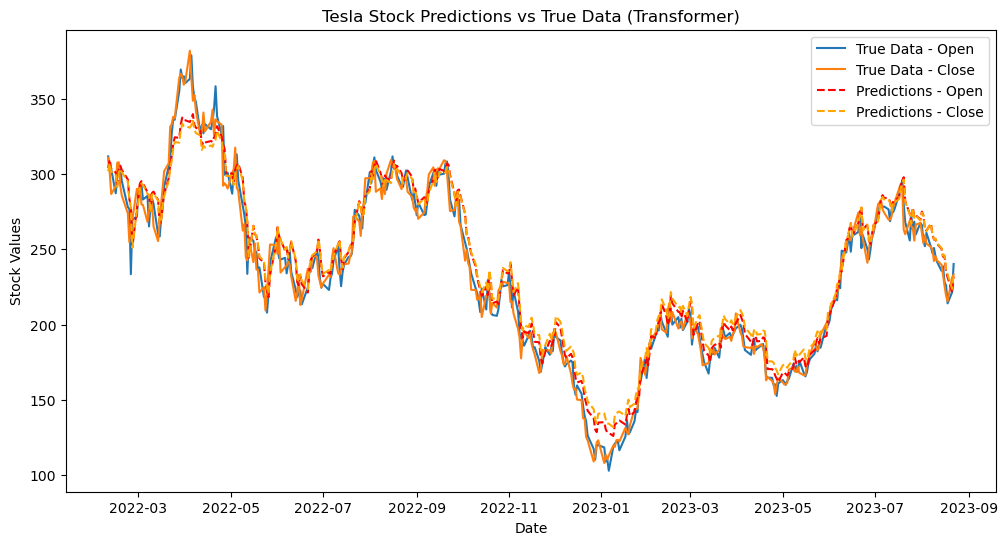

In [19]:
# Make final predictions
model.eval()
with torch.no_grad():
    predictions_final = model(torch.tensor(X_train_tesla, dtype=torch.float32), 
                              torch.tensor(X_train_tesla, dtype=torch.float32))

# Convert predictions back to original scale
# predictions_final_np = scaler.inverse_transform(predictions_final.numpy().reshape(-1, 2))
predictions_final_np = scaler.inverse_transform(predictions_final[:, -1, :].numpy())
y_train_actual = scaler.inverse_transform(y_train_tesla.reshape(-1, 2))

# Plot predictions vs. actual values
plt.figure(figsize=(12, 6))
plt.plot(df_train.index[window_size:], y_train_actual[:, 0], label="True Data - Open")
plt.plot(df_train.index[window_size:], y_train_actual[:, 1], label="True Data - Close")

plt.plot(df_train.index[window_size:], predictions_final_np[:, 0], label="Predictions - Open", color='red', linestyle="dashed")
plt.plot(df_train.index[window_size:], predictions_final_np[:, 1], label="Predictions - Close", color='orange', linestyle="dashed")
plt.legend()
plt.title('Tesla Stock Predictions vs True Data (Transformer)')
plt.xlabel('Date')
plt.ylabel('Stock Values')
plt.show()

Test RMSE: 11.5782


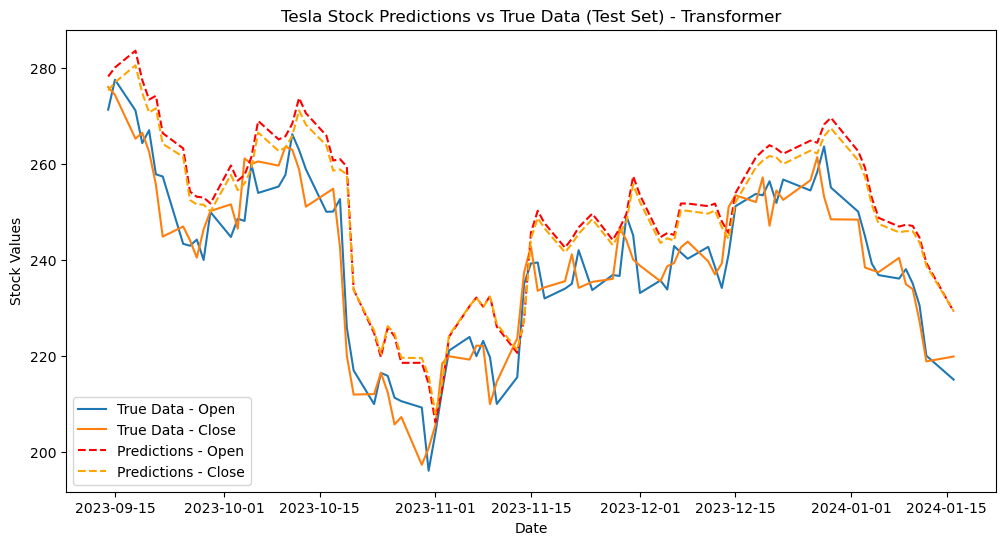

In [32]:
# Prepare test data using the same window size
X_test = [df_test.values[i:i+window_size] for i in range(len(df_test) - window_size)]
y_test = [df_test.values[i + window_size] for i in range(len(df_test) - window_size)]

X_test = np.array(X_test)
y_test = np.array(y_test)

# Convert to PyTorch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Make predictions on test data using the trained Transformer model
model.eval()
with torch.no_grad():
    predictions_test_tensor = model(X_test_tensor, X_test_tensor)  # Decoder input is same as encoder

# Convert predictions back to NumPy array
predictions_test = predictions_test_tensor[:, -1, :].numpy()

# Reverse scaling to get original values
predictions_test = scaler.inverse_transform(predictions_test.reshape(-1, 2))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 2))

# Calculate RMSE for test data
rmse_test = np.sqrt(mean_squared_error(y_test_actual, predictions_test))
print(f"Test RMSE: {rmse_test:.4f}")

# Plot test predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(df_test.index[window_size:], y_test_actual[:, 0], label="True Data - Open")
plt.plot(df_test.index[window_size:], y_test_actual[:, 1], label="True Data - Close")

plt.plot(df_test.index[window_size:], predictions_test[:, 0], label="Predictions - Open", color='red', linestyle="dashed")
plt.plot(df_test.index[window_size:], predictions_test[:, 1], label="Predictions - Close", color='orange', linestyle="dashed")

plt.legend()
plt.title('Tesla Stock Predictions vs True Data (Test Set) - Transformer')
plt.xlabel('Date')
plt.ylabel('Stock Values')
plt.show()

In [37]:
# Load and preprocess data
df_weather = pd.read_excel("weatheraqDataset.xlsx")
df_weather.drop(columns=["Unnamed: 0"], errors="ignore", inplace=True)

df_weather["date"] = pd.to_datetime(df_weather["date"])
df_weather.set_index("date", inplace=True)

df_weather = df_weather[["avg_nitrogen_dioxide", "max_nitrogen_dioxide"]]
df_weather = df_weather.iloc[-500:]  # Last 100 records

# Scale data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_weather)
df_scaled = pd.DataFrame(scaled_data, columns=df_weather.columns, index=df_weather.index)

In [38]:
# Split into train (80%) and test (20%)
train_size = int(len(df_scaled) * 0.8)
df_train = df_scaled.iloc[:train_size]
df_test = df_scaled.iloc[train_size:]

print(f"Training data size: {len(df_train)}")
print(f"Testing data size: {len(df_test)}")

Training data size: 400
Testing data size: 100


In [42]:
# Define hyperparameter search space
model_dims = [16, 32]
learning_rates = [0.01, 0.005, 0.001]
epochs_list = [100, 300, 500]
window_sizes = [5, 10, 15]

best_rmse = float("inf")
best_params = None

# Hyperparameter tuning
for model_dim in model_dims:
    for learning_rate in learning_rates:
        for epochs in epochs_list:
            for window_size in window_sizes:
                print(f"Training with ModelDim={model_dim}, LR={learning_rate}, Epochs={epochs}, Window={window_size}")

                # Prepare training data as sequences
                X_train_weather_tuned = [df_train.values[i:i+window_size] for i in range(len(df_train) - window_size)]
                y_train_weather_tuned = [df_train.values[i + window_size] for i in range(len(df_train) - window_size)]
                
                X_train_weather_tuned = np.array(X_train_weather_tuned)
                y_train_weather_tuned = np.array(y_train_weather_tuned)

                # Initialize Transformer model
                model = TransformerTimeSeries(input_dim=2, model_dim=model_dim, num_heads=4, num_layers=2, dropout=0.1)

                # Define loss function and optimizer
                criterion = nn.MSELoss()
                optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

                # Training loop
                for epoch in range(epochs):
                    model.train()
                    optimizer.zero_grad()

                    # Forward pass
                    Y_pred = model(torch.tensor(X_train_weather_tuned, dtype=torch.float32), 
                                   torch.tensor(X_train_weather_tuned, dtype=torch.float32))

                    # Compute loss
                    loss = criterion(Y_pred[:, -1, :], torch.tensor(y_train_weather_tuned, dtype=torch.float32))


                    # Backpropagation
                    loss.backward()
                    optimizer.step()

                # Make predictions
                model.eval()
                with torch.no_grad():
                    predictions = model(torch.tensor(X_train_weather_tuned, dtype=torch.float32), 
                                        torch.tensor(X_train_weather_tuned, dtype=torch.float32))

                # Convert predictions back to original scale
                predictions_np = scaler.inverse_transform(predictions.numpy().reshape(-1, 2))
                y_train_actual = scaler.inverse_transform(y_train_weather_tuned.reshape(-1, 2))
                # Select only the last predicted step for each sequence to match y_train_actual
                predictions_np = predictions_np[-len(y_train_actual):]

                # Calculate RMSE
                rmse = np.sqrt(mean_squared_error(y_train_actual, predictions_np))
                print(f"RMSE: {rmse:.4f}")

                # Save best model parameters
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_params = (model_dim, learning_rate, epochs, window_size)

# Print best parameters
print("\nBest Hyperparameters for Tesla Stock Data:")
print(f"Model Dim: {best_params[0]}, Learning Rate: {best_params[1]}, Epochs: {best_params[2]}, Window Size: {best_params[3]}")
print(f"Best RMSE: {best_rmse:.4f}")

Training with ModelDim=16, LR=0.01, Epochs=100, Window=5
RMSE: 15.4850
Training with ModelDim=16, LR=0.01, Epochs=100, Window=10
RMSE: 15.5055
Training with ModelDim=16, LR=0.01, Epochs=100, Window=15
RMSE: 15.5594
Training with ModelDim=16, LR=0.01, Epochs=300, Window=5
RMSE: 22.7149
Training with ModelDim=16, LR=0.01, Epochs=300, Window=10
RMSE: 22.2207
Training with ModelDim=16, LR=0.01, Epochs=300, Window=15
RMSE: 20.1284
Training with ModelDim=16, LR=0.01, Epochs=500, Window=5
RMSE: 21.7963
Training with ModelDim=16, LR=0.01, Epochs=500, Window=10
RMSE: 22.6515
Training with ModelDim=16, LR=0.01, Epochs=500, Window=15
RMSE: 20.7215
Training with ModelDim=16, LR=0.005, Epochs=100, Window=5
RMSE: 21.3020
Training with ModelDim=16, LR=0.005, Epochs=100, Window=10
RMSE: 15.6414
Training with ModelDim=16, LR=0.005, Epochs=100, Window=15
RMSE: 20.3666
Training with ModelDim=16, LR=0.005, Epochs=300, Window=5
RMSE: 22.4891
Training with ModelDim=16, LR=0.005, Epochs=300, Window=10
RMSE: 

In [53]:
# Train final Transformer model with best parameters
# window_size = best_params[3]
window_size = 15

X_train_weather = [df_train.values[i:i+window_size] for i in range(len(df_train) - window_size)]
y_train_weather = [df_train.values[i + window_size] for i in range(len(df_train) - window_size)]

X_train_weather = np.array(X_train_weather)
y_train_weather = np.array(y_train_weather)

# model = TransformerTimeSeries(input_dim=2, model_dim=best_params[0], num_heads=4, num_layers=2, dropout=0.1)
model = TransformerTimeSeries(input_dim=2, model_dim=128, num_heads=4, num_layers=4, dropout=0.1)

criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=best_params[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the final model
for epoch in range(500):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    Y_pred = model(torch.tensor(X_train_weather, dtype=torch.float32), 
                   torch.tensor(X_train_weather, dtype=torch.float32))

    # Compute loss
    # loss = criterion(Y_pred, torch.tensor(y_train_tesla, dtype=torch.float32))
    loss = criterion(Y_pred[:, -1, :], torch.tensor(y_train_weather, dtype=torch.float32))

    # Backpropagation
    loss.backward()
    optimizer.step()

print("Final model training completed.")

Final model training completed.


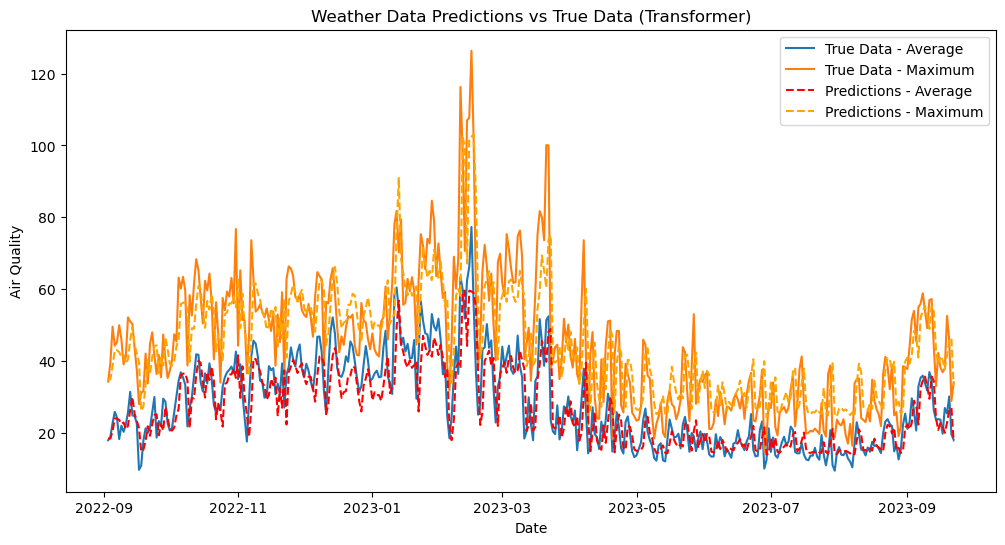

In [54]:
# Make final predictions
model.eval()
with torch.no_grad():
    predictions_final = model(torch.tensor(X_train_weather, dtype=torch.float32), 
                              torch.tensor(X_train_weather, dtype=torch.float32))

# Convert predictions back to original scale
# predictions_final_np = scaler.inverse_transform(predictions_final.numpy().reshape(-1, 2))
predictions_final_np = scaler.inverse_transform(predictions_final[:, -1, :].numpy())
y_train_actual = scaler.inverse_transform(y_train_weather.reshape(-1, 2))

# Plot predictions vs. actual values
plt.figure(figsize=(12, 6))
plt.plot(df_train.index[window_size:], y_train_actual[:, 0], label="True Data - Average")
plt.plot(df_train.index[window_size:], y_train_actual[:, 1], label="True Data - Maximum")

plt.plot(df_train.index[window_size:], predictions_final_np[:, 0], label="Predictions - Average", color='red', linestyle="dashed")
plt.plot(df_train.index[window_size:], predictions_final_np[:, 1], label="Predictions - Maximum", color='orange', linestyle="dashed")
plt.legend()
plt.title('Weather Data Predictions vs True Data (Transformer)')
plt.xlabel('Date')
plt.ylabel('Air Quality')
plt.show()

# # Train with best hyperparameters
# window_size = best_params[3]

# X_train_final = [df_train.values[i:i+window_size] for i in range(len(df_train) - window_size)]
# y_train_final = [df_train.values[i + window_size] for i in range(len(df_train) - window_size)]

# X_train_final = np.array(X_train_final)
# y_train_final = np.array(y_train_final)

# X_train_tensor_final = torch.tensor(X_train_final, dtype=torch.float32)
# y_train_tensor_final = torch.tensor(y_train_final, dtype=torch.float32)

# final_model = TransformerTimeSeries(input_dim=2, model_dim=best_params[0], num_heads=4, num_layers=2, dropout=0.1)
# optimizer = optim.Adam(final_model.parameters(), lr=best_params[1])

# # Final Training
# for epoch in range(best_params[2]):
#     final_model.train()
#     optimizer.zero_grad()
#     Y_pred = final_model(X_train_tensor_final)
#     loss = criterion(Y_pred, y_train_tensor_final)
#     loss.backward()
#     optimizer.step()

# # Evaluate final model
# final_model.eval()
# with torch.no_grad():
#     predictions_final = final_model(X_train_tensor_final)

# # Convert predictions back to original scale
# predictions_final_np = scaler.inverse_transform(predictions_final.numpy().reshape(-1, 2))
# y_train_actual_final = scaler.inverse_transform(y_train_final.reshape(-1, 2))

# # Plot actual vs predicted values
# plt.figure(figsize=(12, 6))
# plt.plot(df_train.index[window_size:], y_train_actual_final[:, 0], label="True Data - Average")
# plt.plot(df_train.index[window_size:], y_train_actual_final[:, 1], label="True Data - Maximum")

# plt.plot(df_train.index[window_size:], predictions_final_np[:, 0], label="Predictions - Average", color='red', linestyle="dashed")
# plt.plot(df_train.index[window_size:], predictions_final_np[:, 1], label="Predictions - Maximum", color='orange', linestyle="dashed")

# plt.legend()
# plt.title('Weather Data Predictions vs True Data (Transformer)')
# plt.xlabel('Date')
# plt.ylabel('Air Data')
# plt.show()

Test RMSE: 11.1252


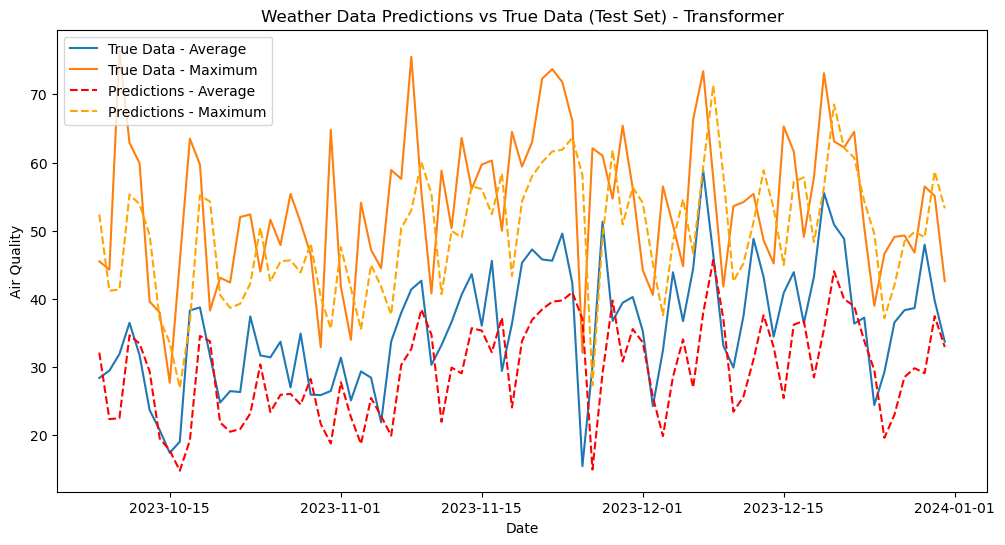

In [55]:
# Prepare test data using the same window size
X_test = [df_test.values[i:i+window_size] for i in range(len(df_test) - window_size)]
y_test = [df_test.values[i + window_size] for i in range(len(df_test) - window_size)]

X_test = np.array(X_test)
y_test = np.array(y_test)

# Convert to PyTorch tensors
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Make predictions on test data using the trained Transformer model
model.eval()
with torch.no_grad():
    predictions_test_tensor = model(X_test_tensor, X_test_tensor)  # Decoder input is same as encoder

# Convert predictions back to NumPy array
predictions_test = predictions_test_tensor[:, -1, :].numpy()

# Reverse scaling to get original values
predictions_test = scaler.inverse_transform(predictions_test.reshape(-1, 2))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 2))

# Calculate RMSE for test data
rmse_test = np.sqrt(mean_squared_error(y_test_actual, predictions_test))
print(f"Test RMSE: {rmse_test:.4f}")

# Plot test predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(df_test.index[window_size:], y_test_actual[:, 0], label="True Data - Average")
plt.plot(df_test.index[window_size:], y_test_actual[:, 1], label="True Data - Maximum")

plt.plot(df_test.index[window_size:], predictions_test[:, 0], label="Predictions - Average", color='red', linestyle="dashed")
plt.plot(df_test.index[window_size:], predictions_test[:, 1], label="Predictions - Maximum", color='orange', linestyle="dashed")

plt.legend()
plt.title('Weather Data Predictions vs True Data (Test Set) - Transformer')
plt.xlabel('Date')
plt.ylabel('Air Quality')
plt.show()

# # Prepare test data using the same window size
# X_test = [df_test.values[i:i+window_size] for i in range(len(df_test) - window_size)]
# y_test = [df_test.values[i + window_size] for i in range(len(df_test) - window_size)]

# X_test = np.array(X_test)
# y_test = np.array(y_test)

# # Convert test data to tensors
# X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
# y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# # Ensure model is in evaluation mode
# final_model.eval()

# # Make predictions on test data using the trained model
# with torch.no_grad():
#     predictions_test = final_model(X_test_tensor)

# # Convert predictions back to original scale
# predictions_test_np = scaler.inverse_transform(predictions_test.numpy().reshape(-1, 2))
# y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 2))

# # Calculate RMSE for test data
# rmse_test = np.sqrt(mean_squared_error(y_test_actual, predictions_test_np))
# print(f"Test RMSE: {rmse_test:.4f}")

# # Plot test predictions vs actual values
# plt.figure(figsize=(12, 6))
# plt.plot(df_test.index[window_size:], y_test_actual[:, 0], label="True Data - Average")
# plt.plot(df_test.index[window_size:], y_test_actual[:, 1], label="True Data - Maximum")

# plt.plot(df_test.index[window_size:], predictions_test_np[:, 0], label="Predictions - Average", color='red', linestyle="dashed")
# plt.plot(df_test.index[window_size:], predictions_test_np[:, 1], label="Predictions - Maximum", color='orange', linestyle="dashed")

# plt.legend()
# plt.title('Weather Data Predictions vs True Data (Test Set)')
# plt.xlabel('Date')
# plt.ylabel('Air Quality')
# plt.show()